# 양자화 에러

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=None):
    """
    Plot a heatmap of tensors using seaborn
    """
    sns.heatmap(tensor.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


def plot_quantization_errors(original_tensor, quantized_tensor, dequantized_tensor, dtype = torch.int8, n_bits = 8):
    """
    A method that plots 4 matrices, the original tensor, the quantized tensor
    the de-quantized tensor and the error tensor.
    """
    # Get a figure of 4 plots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first matrix
    plot_matrix(original_tensor, axes[0], 'Original Tensor', cmap=ListedColormap(['white']))

    # Get the quantization range and plot the quantized tensor
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    plot_matrix(quantized_tensor, axes[1], f'{n_bits}-bit Linear Quantized Tensor', vmin=q_min, vmax=q_max, cmap='coolwarm')

    # Plot the de-quantized tensors
    plot_matrix(dequantized_tensor, axes[2], 'Dequantized Tensor', cmap='coolwarm')

    # Get the quantization errors
    q_error_tensor = abs(original_tensor - dequantized_tensor)
    plot_matrix(q_error_tensor, axes[3], 'Quantization Error Tensor', cmap=ListedColormap(['white']))

    fig.tight_layout()
    plt.show()

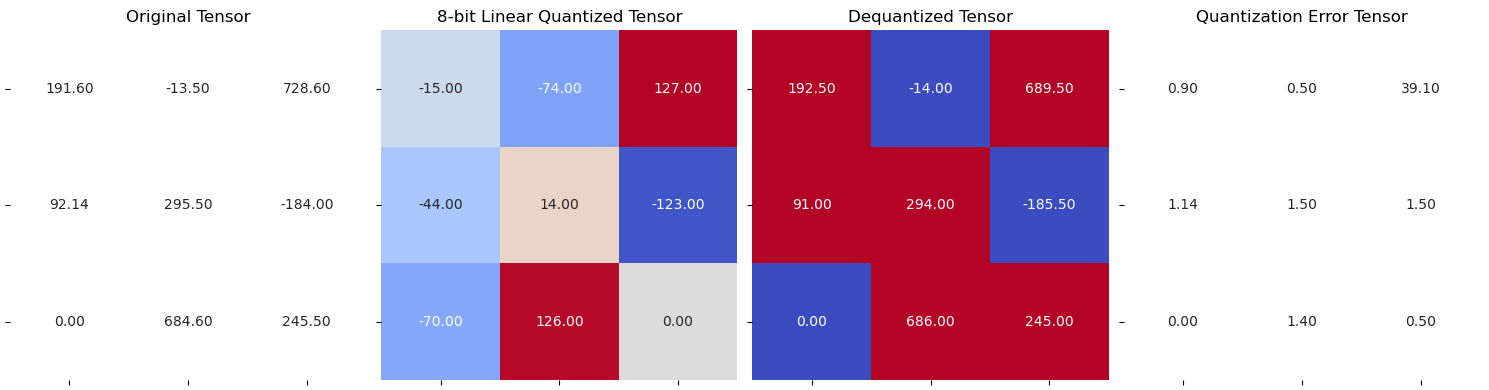

In [3]:
scale = 3.5
zero_point = -70
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

def linear_quantization(
    tensor, scale, zero_point, dtype = torch.int8):

    scaled_and_shifted_tensor = tensor / scale + zero_point

    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    
    return q_tensor


def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

quantized_tensor = linear_quantization(test_tensor, scale, zero_point)
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)


plot_quantization_errors(test_tensor, quantized_tensor,dequantized_tensor)

In [4]:
print((dequantized_tensor - test_tensor).square().mean())

tensor(170.8753)


# 양자화의 Scale과 Zero-Point 찾기

In [5]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)

    zero_point = q_min - (r_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        # round and cast to int
        zero_point = int(round(zero_point))
    
    return scale, zero_point



new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)
print(new_scale, new_zero_point)

3.578823433670343 -77


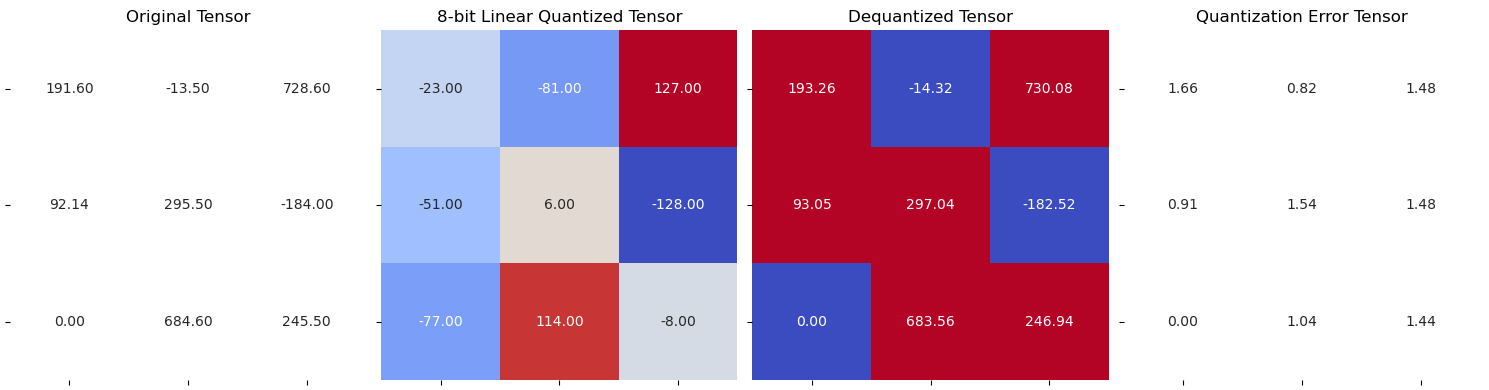

In [7]:
quantized_tensor = linear_quantization(test_tensor, new_scale, new_zero_point)
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)

plot_quantization_errors(test_tensor, quantized_tensor,dequantized_tensor)